## Lab 2 - Homework


In [1]:
import duckdb

db = duckdb.connect("data/duckdb_trains.db")
db

### 2. Put stations data into stations table in DuckDB. This changes rarely, so we treat it as a almost constant file.


In [3]:
# stations
db.sql(
    """
DROP TABLE IF EXISTS stations;
CREATE TABLE stations AS
FROM read_csv(['data/stations-2023-09.csv'], union_by_name = true);       
"""
)

In [5]:
# services
services_files = [f"'data/services-{year}.csv'" for year in range(2019, 2024)]

for i in range(1, 10):
    services_files.append(f"'data/services-2025-0{i}.csv'")

db.sql(
    f"""
DROP TABLE IF EXISTS services;
CREATE TABLE services AS
FROM read_csv([{', '.join(services_files)}], union_by_name = true);       
"""
)

### 3. Based on DuckDB tutorial, create tables distances and distances_long. We treat this similarly to stations table.


In [7]:
db.sql(
    f"""
CREATE TABLE distances AS
    FROM read_csv(
        'data/tariff-distances-2022-01.csv',
        nullstr = 'XXX'
    );      
"""
)

In [8]:
db.sql(
    f"""
FROM (DESCRIBE distances)
LIMIT 5;     
"""
)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Station     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ AC          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AH          │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHP         │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ AHPR        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [9]:
db.sql(
    f"""
SELECT #1, #2, #3, #4, #5, #6, #7, #8, #9
FROM distances
LIMIT 8;  
"""
)

┌─────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Station │  AC   │  AH   │  AHP  │ AHPR  │  AHZ  │  AKL  │  AKM  │  ALM  │
│ varchar │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │ int64 │
├─────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ AC      │  NULL │    82 │    83 │    85 │    90 │    71 │   188 │    32 │
│ AH      │    82 │  NULL │     1 │     3 │     8 │    77 │   153 │    98 │
│ AHP     │    83 │     1 │  NULL │     2 │     9 │    78 │   152 │    99 │
│ AHPR    │    85 │     3 │     2 │  NULL │    11 │    80 │   150 │   101 │
│ AHZ     │    90 │     8 │     9 │    11 │  NULL │    69 │   161 │   106 │
│ AKL     │    71 │    77 │    78 │    80 │    69 │  NULL │   211 │    96 │
│ AKM     │   188 │   153 │   152 │   150 │   161 │   211 │  NULL │   158 │
│ ALM     │    32 │    98 │    99 │   101 │   106 │    96 │   158 │  NULL │
└─────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

In [11]:
db.sql(
    f"""
CREATE TABLE distances_long AS
    UNPIVOT distances
    ON COLUMNS (* EXCLUDE station)
    INTO NAME other_station VALUE distance;
"""
)

In [12]:
db.sql(
    f"""
SELECT station, other_station, distance
FROM distances_long
LIMIT 3;
"""
)

┌─────────┬───────────────┬──────────┐
│ Station │ other_station │ distance │
│ varchar │    varchar    │  int64   │
├─────────┼───────────────┼──────────┤
│ AC      │ AH            │       82 │
│ AC      │ AHP           │       83 │
│ AC      │ AHPR          │       85 │
└─────────┴───────────────┴──────────┘

### 4. Put train disruptions into disruptions table in the Postgres database. We expect this data to change regularly, and thus treat it as a typical OLTP table.


In [17]:
db.sql("""INSTALL postgres; LOAD postgres;""")
conn_string = "host=localhost user=postgres password=postgres dbname=postgres"
db.sql(
    f"""
ATTACH IF NOT EXISTS '{conn_string}' AS postgres_db_rw (TYPE postgres);
"""
)

db.sql("SHOW ALL TABLES")

┌────────────────┬─────────┬────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [18]:
# disruptions
disruption_files = [f"'data/disruptions-{year}.csv'" for year in range(2011, 2025)]
db.sql(
    f"""
DROP TABLE IF EXISTS postgres_db_rw.disruptions;
CREATE TABLE postgres_db_rw.disruptions AS
SELECT *
FROM read_csv([{', '.join(disruption_files)}], union_by_name = true);       
"""
)

In [21]:
db.sql("SHOW ALL TABLES")

┌────────────────┬─────────┬────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### 5. Transform train services CSV files into a single Parquet file. Make table services from it. We treat this as a big data batch input, created rarely but regularly for analytics purposes.


In [22]:
db.sql(
    """
COPY services TO 'data/services.parquet' (FORMAT PARQUET, COMPRESSION zstd);
"""
)

In [23]:
db.sql(
    """
DROP TABLE IF EXISTS services;
CREATE TABLE services AS
SELECT * FROM read_parquet('data/services.parquet');
"""
)

In [26]:
db.sql("SHOW ALL TABLES")

┌────────────────┬─────────┬────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

### 6/7. Queries


In [30]:
# How many trains departed from Amsterdam Central station overall?
db.sql(
    """
SELECT COUNT(DISTINCT "Service:RDT-ID") as train_count
FROM services
WHERE "Stop:Station name" = 'Amsterdam Centraal'
  AND "Stop:Arrival time" IS NULL;
"""
)

┌─────────────┐
│ train_count │
│    int64    │
├─────────────┤
│      951111 │
└─────────────┘

In [33]:
# Calculate the average arrival delay of different service types (Service:Type). Order results descending by average delay.
db.sql(
    """
SELECT "Service:Type" as type, 
       AVG(COALESCE("Stop:Arrival delay", 0)) as avg_delay
FROM services
GROUP BY "Service:Type"
ORDER BY avg_delay DESC;
"""
)

┌──────────────────────┬────────────────────┐
│         type         │     avg_delay      │
│       varchar        │       double       │
├──────────────────────┼────────────────────┤
│ Alpen Express        │ 21.956190476190475 │
│ European Sleeper     │ 12.433940988535989 │
│ Krokus Express       │ 11.378378378378379 │
│ Nightjet             │  7.919753221227342 │
│ Eurostar             │  5.194232452752459 │
│ ICE International    │  4.554430301580073 │
│ Thalys               │  4.366045308646701 │
│ Int. Trein           │ 3.9446540880503145 │
│ Nachttrein           │ 3.2477390180878554 │
│ Stoomtrein           │ 2.1440329218106995 │
│     ·                │                 ·  │
│     ·                │                 ·  │
│     ·                │                 ·  │
│ Tram ipv trein       │                0.0 │
│ Metro                │                0.0 │
│ stoptrein            │                0.0 │
│ Niet instappen       │                0.0 │
│ Taxibus ipv trein    │          

In [56]:
# What was the most common disruption cause in different years? MODE function may be useful.
db.sql(
    """
SELECT MODE(statistical_cause_en) as cause, extract('year' FROM start_time) as year
FROM postgres_db_rw.disruptions
GROUP BY year
ORDER BY year DESC;
"""
)

┌───────────────────┬───────┐
│       cause       │ year  │
│      varchar      │ int64 │
├───────────────────┼───────┤
│ broken down train │  2024 │
│ broken down train │  2023 │
│ broken down train │  2022 │
│ broken down train │  2021 │
│ broken down train │  2020 │
│ broken down train │  2019 │
│ broken down train │  2018 │
│ broken down train │  2017 │
│ broken down train │  2016 │
│ broken down train │  2015 │
│ broken down train │  2014 │
│ points failure    │  2013 │
│ points failure    │  2012 │
│ broken down train │  2011 │
├───────────────────┴───────┤
│ 14 rows         2 columns │
└───────────────────────────┘

In [57]:
# How many trains started their overall service in any Amsterdam station?
db.sql(
    """
SELECT COUNT(DISTINCT "Service:RDT-ID") as count
FROM services
WHERE "Stop:Station name" LIKE 'Amsterdam%'
  AND "Stop:Arrival time" IS NULL;
"""
)

┌─────────┐
│  count  │
│  int64  │
├─────────┤
│ 1064378 │
└─────────┘

I'm not sure if I understand the question correctly, but I can't find any good way to identify the specific trains.


In [62]:
# What fraction of services was run to final destinations outside the Netherlands?
db.sql(
    """
WITH destination AS (
    SELECT DISTINCT s."Service:RDT-ID", st.country
    FROM services s
    LEFT JOIN stations st ON s."Stop:Station code" = st.code
    WHERE s."Stop:Departure time" IS NULL
),
outside AS (
    SELECT COUNT(DISTINCT "Service:RDT-ID") as outside_count
    FROM destination
    WHERE country != 'NL'
)
SELECT outside_count / (SELECT COUNT(*) FROM destination) as fraction
FROM outside;
"""
)

┌─────────────────────┐
│      fraction       │
│       double        │
├─────────────────────┤
│ 0.03700292533763597 │
└─────────────────────┘

In [68]:
# What is the largest distance between stations in the Netherlands (code NL)?
db.sql(
    """
SELECT MAX(dl.distance) as distance
FROM distances_long dl
LEFT JOIN stations s1 ON dl.station = s1.code
LEFT JOIN stations s2 ON dl.other_station = s2.code
WHERE s1.country = 'NL' AND s2.country = 'NL';
"""
)

┌──────────┐
│ distance │
│  int64   │
├──────────┤
│      426 │
└──────────┘

<Axes: title={'center': 'Average arrival delay by train operator'}, xlabel='Train Operator', ylabel='Average arrival delay'>

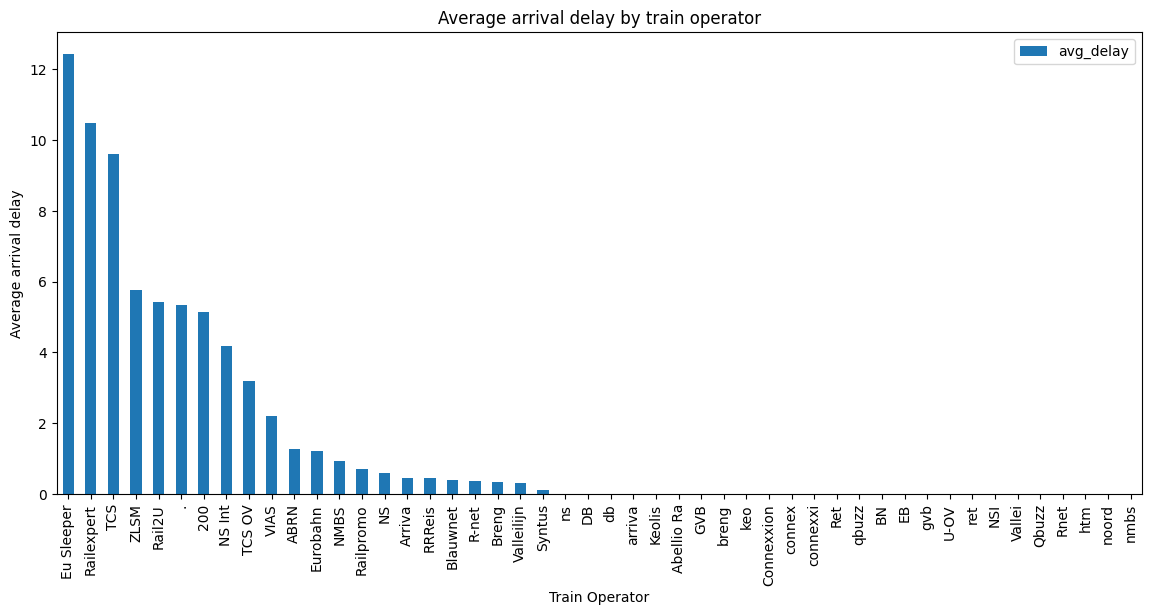

In [80]:
# Compare the average arrival delay between different train operators (Service:Company) on a bar plot. Sort them appropriately.
import matplotlib.pyplot as plt

result = db.sql(
    """
SELECT "Service:Company" as company, 
       AVG(COALESCE("Stop:Arrival delay", 0)) as avg_delay
FROM services
GROUP BY "Service:Company"
ORDER BY avg_delay DESC;
"""
).df()

result.plot.bar(
    x="company",
    y="avg_delay",
    legend=True,
    figsize=(14, 6),
    title="Average arrival delay by train operator",
    ylabel="Average arrival delay",
    xlabel="Train Operator",
)

<Axes: title={'center': 'Number of train service disruptions by year'}, xlabel='Year', ylabel='Number of disruptions'>

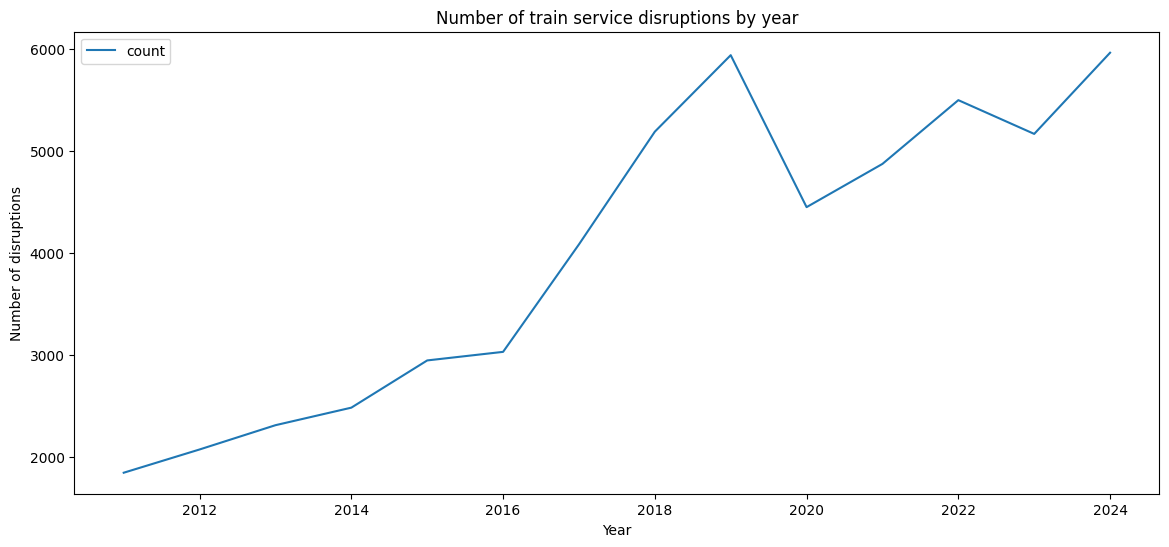

In [81]:
# How many services were disrupted in different years? Make a line plot.
result = db.sql(
    """
SELECT EXTRACT('year' FROM start_time) as year, 
       COUNT(*) as count
FROM postgres_db_rw.disruptions
GROUP BY year
ORDER BY year;
"""
).df()

result.plot(
    x="year",
    y="count",
    legend=True,
    figsize=(14, 6),
    title="Number of train service disruptions by year",
    ylabel="Number of disruptions",
    xlabel="Year",
)

<Axes: title={'center': 'Fraction of cancelled train services by year'}, xlabel='Year', ylabel='Fraction of cancelled services'>

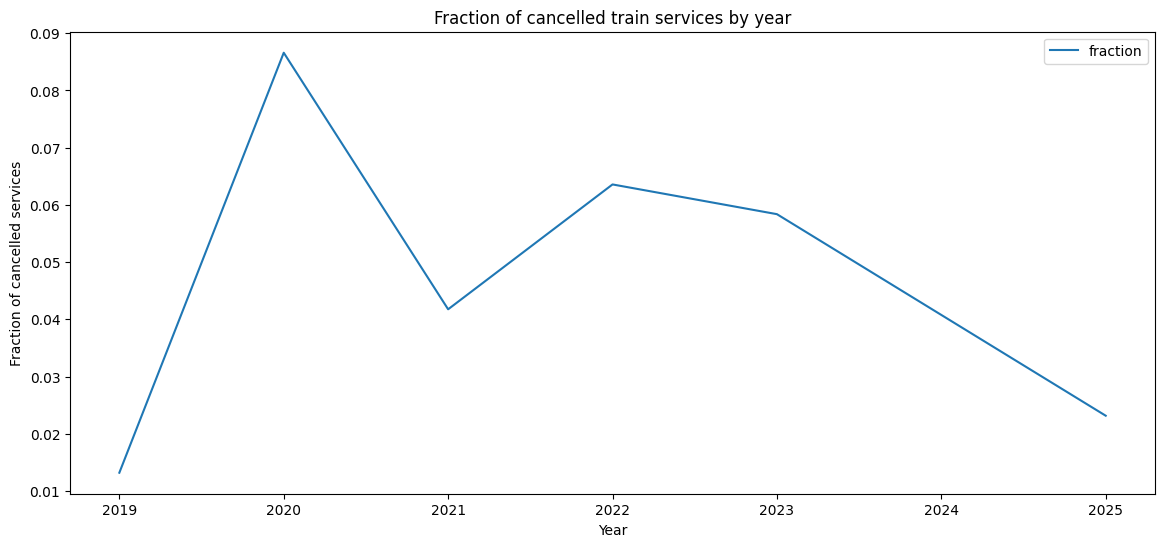

In [85]:
# What fraction of all services were cancelled (Service:Completely cancelled) in different years? Make a line plot.
result = db.sql(
    """
WITH yearly_cancelled_totals AS (
    SELECT 
        EXTRACT('year' FROM "Service:Date") as year,
        COUNT(DISTINCT "Service:RDT-ID") as total
    FROM services
    WHERE "Service:Completely cancelled" = true
    GROUP BY year
),
yearly_totals AS (
    SELECT 
        EXTRACT('year' FROM "Service:Date") as year,
        COUNT(DISTINCT "Service:RDT-ID") as total
    FROM services
    GROUP BY year
)
SELECT 
    yt.year,
    yct.total / yt.total as fraction
FROM yearly_totals yt
LEFT JOIN yearly_cancelled_totals yct ON yt.year = yct.year
ORDER BY yt.year;
"""
).df()

result.plot(
    x="year",
    y="fraction",
    legend=True,
    figsize=(14, 6),
    title="Fraction of cancelled train services by year",
    ylabel="Fraction of cancelled services",
    xlabel="Year",
)

### 8. Currently, services table does not ...


In [91]:
db.sql(
    """
DROP TABLE IF EXISTS station_connections;
CREATE TABLE station_connections AS
WITH next_stops AS (
    SELECT
        "Service:RDT-ID",
        "Stop:Station code" AS start_station_code,
        LEAD("Stop:Station code") OVER (
            PARTITION BY "Service:RDT-ID"
            ORDER BY COALESCE("Stop:Departure time", "Stop:Arrival time")
        ) AS end_station_code
    FROM services
),
pairs AS (
    SELECT DISTINCT 
        "Service:RDT-ID",
        LEAST(start_station_code, end_station_code) AS start_station_code,
        GREATEST(start_station_code, end_station_code) AS end_station_code
    FROM next_stops
    WHERE end_station_code IS NOT NULL
      AND start_station_code IS NOT NULL
)
SELECT
    "Service:RDT-ID",
    up.start_station_code AS start_station_code,
    up.end_station_code AS end_station_code,
    COALESCE(d1.distance, d2.distance) AS distance
FROM pairs up
LEFT JOIN distances_long d1 
    ON up.start_station_code = d1.station 
   AND up.end_station_code = d1.other_station
LEFT JOIN distances_long d2 
    ON up.end_station_code = d2.station 
   AND up.start_station_code = d2.other_station;
"""
)

db.sql("SELECT * FROM station_connections LIMIT 20;")

┌────────────────┬────────────────────┬──────────────────┬──────────┐
│ Service:RDT-ID │ start_station_code │ end_station_code │ distance │
│     int64      │      varchar       │     varchar      │  int64   │
├────────────────┼────────────────────┼──────────────────┼──────────┤
│        7835923 │ GD                 │ GVC              │       28 │
│        7839791 │ ALM                │ ALMB             │        6 │
│        7852592 │ DB                 │ VNDW             │       22 │
│        7855917 │ ASS                │ ZD               │        6 │
│        7857886 │ ES                 │ HGL              │        8 │
│        7860099 │ TL                 │ TPSW             │        2 │
│        7861781 │ RLB                │ RTZ              │        3 │
│        7869260 │ BDG                │ WD               │       11 │
│        7870887 │ RL                 │ VD               │       10 │
│        7871630 │ ASDM               │ ASSP             │        1 │
│        7878862 │ G

In [92]:
# What is the largest distance between a pair of stations?
db.sql(
    """
SELECT MAX(distance) as max_distance
FROM station_connections;
"""
)

┌──────────────┐
│ max_distance │
│    int64     │
├──────────────┤
│          417 │
└──────────────┘

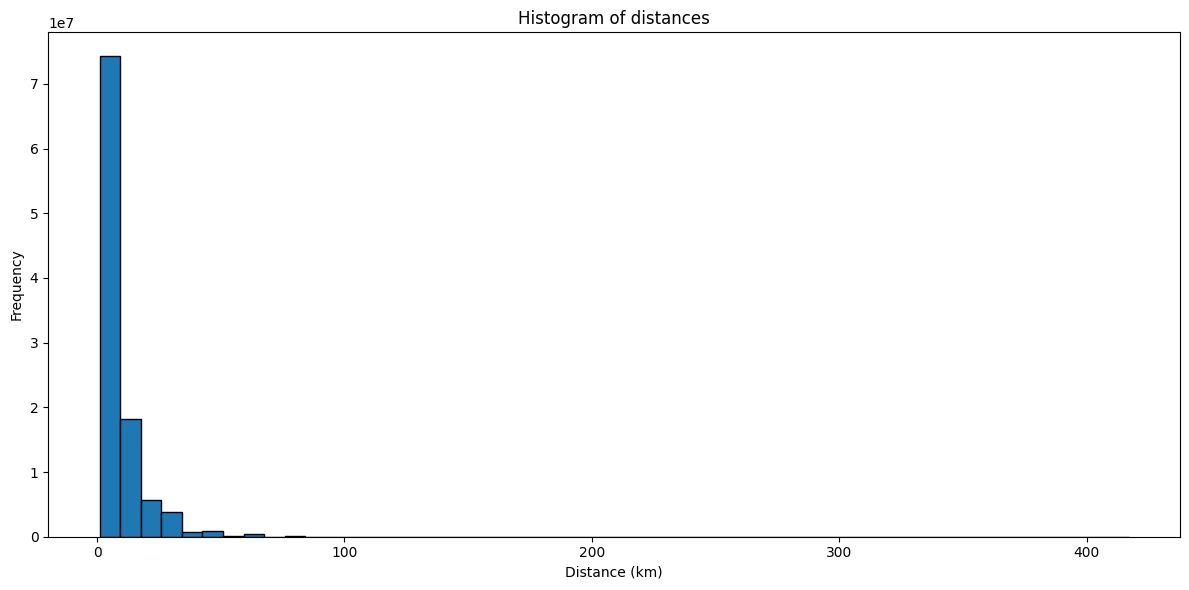

In [96]:
result = db.sql(
    """
SELECT distance
FROM station_connections
WHERE distance IS NOT NULL;
"""
).df()

plt.figure(figsize=(12, 6))
plt.hist(result["distance"], bins=50, edgecolor="black")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.title("Histogram of distances")
plt.tight_layout()